# Time Series Prediction


In [3]:
# @ Lukman copyright 
# MIT Licence

In [1]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 

# imports below are for plotly 
import ipywidgets as widgets
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)   # for offline mode use
import plotly.figure_factory as ff
import plotly.offline as offline


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random

# Data Preprocessing 

In [2]:
# I will Load only the zero meter data set 
# same syntax applied for other data set
meterOneDataLOaded= pd.read_csv('meterOneTrainData.csv')
# all meter types data set could be analysed in same manner

In [3]:
meterOneDataLOaded[1:3]

,Unnamed: 0,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1,1,162,1,2016-01-01 00:00:00,0.0000,2,Education,98829,1968.0,NaN,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
2,2,163,1,2016-01-01 00:00:00,4.5719,2,Education,72102,1970.0,NaN,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6


In [4]:
# delete column unnmaed
del meterOneDataLOaded['Unnamed: 0']

In [5]:
# column values 
meterOneDataLOaded.columns.tolist()

['building_id',
 'meter',
 'timestamp',
 'meter_reading',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [6]:
# store column as list
columns = meterOneDataLOaded.columns.tolist()

In [7]:
# get null values per column in the data set
meterOneDataLOaded.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            2819559
floor_count           3972549
air_temperature         23502
cloud_coverage        1742296
dew_temperature         24341
precip_depth_1_hr      541565
sea_level_pressure     105047
wind_direction         402544
wind_speed              37330
dtype: int64

In [8]:
# chnage to time sta
meterOneDataLOaded['timestamp'] =  pd.to_datetime(meterOneDataLOaded['timestamp'])


In [9]:
# check the unique time stamp present
pd.DatetimeIndex(meterOneDataLOaded['timestamp']).year.unique()

Int64Index([2016], dtype='int64', name='timestamp')

In [10]:
meterOneDataLOaded.dtypes

building_id                    int64
meter                          int64
timestamp             datetime64[ns]
meter_reading                float64
site_id                        int64
primary_use                   object
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
dtype: object

In [11]:
# choose windpseed because it has fewer null values
meterOneDataLOaded.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            2819559
floor_count           3972549
air_temperature         23502
cloud_coverage        1742296
dew_temperature         24341
precip_depth_1_hr      541565
sea_level_pressure     105047
wind_direction         402544
wind_speed              37330
dtype: int64

In [12]:
# set time stamp as index 
meterOneDataLOaded.set_index('timestamp',inplace=True);


In [13]:
meterOneDataLOaded['dew_temperature'][1:2]

timestamp
2016-01-01   -5.6
Name: dew_temperature, dtype: float64

#### Model 


In [14]:
# a subset of the data has been copied to use to test the visualizer function
# use the full data set if space is available and system is fast

train_test = meterOneDataLOaded[['meter_reading', 'square_feet', 'air_temperature','primary_use','site_id','dew_temperature']][1:30000].copy()


In [15]:

# reset the index so that time is no longer the index
# the index is now  numbers 
train_test.reset_index(level=0, inplace=True)


In [16]:
# only 2016 data is represented here as usual
pd.DatetimeIndex(train_test['timestamp']).year.unique()

Int64Index([2016], dtype='int64', name='timestamp')

In [17]:
# extrac year month and day
train_test['year'] = pd.DatetimeIndex(train_test['timestamp']).year
train_test['month'] = pd.DatetimeIndex(train_test['timestamp']).month
train_test['day'] = pd.DatetimeIndex(train_test['timestamp']).day

In [18]:
# check null values
train_test.isnull().sum()

timestamp             0
meter_reading         0
square_feet           0
air_temperature    1836
primary_use           0
site_id               0
dew_temperature    1836
year                  0
month                 0
day                   0
dtype: int64

In [19]:
# check data types
train_test.dtypes

timestamp          datetime64[ns]
meter_reading             float64
square_feet                 int64
air_temperature           float64
primary_use                object
site_id                     int64
dew_temperature           float64
year                        int64
month                       int64
day                         int64
dtype: object

In [20]:
# forward filling missing values since values from previous timestamp should
# ideally be similar to the next one. (temperature today and tomorrow should be quite similar)
train_test['air_temperature'].fillna(method='ffill', inplace=True)
train_test['dew_temperature'].fillna(method='ffill', inplace=True)

In [21]:
# delete year we wont use the year information in the model
del train_test['year']

In [22]:
# encode site id and primary use
train_test = pd.get_dummies(train_test, columns=["primary_use","site_id"])

In [23]:
train_test.head()

,timestamp,meter_reading,square_feet,air_temperature,dew_temperature,month,day,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,...,primary_use_Utility,site_id_2,site_id_6,site_id_7,site_id_9,site_id_10,site_id_11,site_id_13,site_id_14,site_id_15
0,2016-01-01,0.0000,98829,15.6,-5.6,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2016-01-01,4.5719,72102,15.6,-5.6,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2016-01-01,209.8860,553210,15.6,-5.6,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2016-01-01,0.0000,86323,15.6,-5.6,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2016-01-01,51.5570,183460,15.6,-5.6,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [24]:
# set time as index
train_test.set_index('timestamp',inplace=True);


In [25]:
train_test[1:2]

,meter_reading,square_feet,air_temperature,dew_temperature,month,day,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,...,primary_use_Utility,site_id_2,site_id_6,site_id_7,site_id_9,site_id_10,site_id_11,site_id_13,site_id_14,site_id_15
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01,4.5719,72102,15.6,-5.6,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
train_test.columns

Index(['meter_reading', 'square_feet', 'air_temperature', 'dew_temperature',
       'month', 'day', 'primary_use_Education',
       'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Technology/science',
       'primary_use_Utility', 'site_id_2', 'site_id_6', 'site_id_7',
       'site_id_9', 'site_id_10', 'site_id_11', 'site_id_13', 'site_id_14',
       'site_id_15'],
      dtype='object')

##### Extract the predictor and featues

In [27]:
train_test.head()

,meter_reading,square_feet,air_temperature,dew_temperature,month,day,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,...,primary_use_Utility,site_id_2,site_id_6,site_id_7,site_id_9,site_id_10,site_id_11,site_id_13,site_id_14,site_id_15
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.0000,98829,15.6,-5.6,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-01-01,4.5719,72102,15.6,-5.6,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-01-01,209.8860,553210,15.6,-5.6,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-01-01,0.0000,86323,15.6,-5.6,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-01-01,51.5570,183460,15.6,-5.6,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
target = train_test[['meter_reading']].copy(deep=True)

In [29]:
target.shape

(29999, 1)

In [30]:
del train_test['meter_reading']# delete target variable

In [31]:
#train_test = train_test.values.astype('float')

#### Training-Validation Spearation


In [32]:
#img_size=10;
VALIDATION_SIZE = 1000

validation_set = train_test[:VALIDATION_SIZE].values
validation_target = target[:VALIDATION_SIZE].values

train_set = train_test[VALIDATION_SIZE:].values
train_target = target[VALIDATION_SIZE:].values

print('validation-set',validation_set.shape, '|' ,'Train-set', train_set.shape)
print('------------------------------------------------')
print('validation-target',validation_target.shape,'|','Train-Target' ,train_target.shape)


validation-set (1000, 28) | Train-set (28999, 28)
------------------------------------------------
validation-target (1000, 1) | Train-Target (28999, 1)


In [33]:
def Standardize(array):
    '''
    Standardize an array along eachcolumn (each feature that is)
    '''
    transformer = MaxAbsScaler().fit(array)
    output = transformer.transform(array)
    return  np.array(output)

In [34]:
validation_set = Standardize(validation_set)
validation_target = Standardize(validation_target)
#train_set = Standardize(train_set)
#train_target =  Standardize(train_target)



In [35]:
#validation_set.astype(np.float64, copy=False);

In [36]:
#train_set.astype(np.float64, copy=False);

In [37]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_set.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_set
    global train_target
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_set = train_set[perm]
        train_target = train_target[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_set[start:end], train_target[start:end]

In [38]:
import random
def valdation_random_sampler(validation_set, validation_target, n_validation_sample):    
    rng = np.random.RandomState(42)  # reproducible results with a fixed seed
    indices = random.sample(range(0, len(validation_set)-1), n_validation_sample)
    #indices = np.arange(n_samples)
    
    rng.shuffle(indices)
    #print(indices)
    x_shuffled = validation_set[indices]
    y_shuffled = validation_target[indices]
    return x_shuffled,y_shuffled

In [39]:
a,b= valdation_random_sampler(validation_set, validation_target,10)

### Modelling with LSTM

In [40]:
#Input Params
with tf.name_scope("input_target_placeholders"):    
    input_dim = 1
    ##The Input Layer as a Placeholder
    #Since we will provide data sequentially, the 'batch size'
    #is 1.
    input_layer = tf.placeholder(tf.float32, [1, input_dim*train_set.shape[1]],name="input_data")
    correct_output = tf.placeholder(tf.float32, [input_dim],name="target_data")

In [41]:
with tf.variable_scope("lstmLayer",reuse=tf.AUTO_REUSE ):    
    lstm_layer1 = rnn_cell.BasicLSTMCell(input_dim*2042,state_is_tuple=False)
    #lstm_layer1 = rnn_cell.BasicLSTMCell(input_dim*1,state_is_tuple=True)

    #The LSTM state as a Variable initialized to zeroes
    lstm_state1 = tf.Variable(tf.zeros([1, lstm_layer1.state_size]),trainable=False,name="initial_state")
    #lstm_state1 = tf.Variable(lstm_layer1.zero_state(1,lstm_layer1.state_size[-1] ), trainable=False)
    #Connect the input layer and initial LSTM state to the LSTM cell
    lstm_output1, lstm_state_output1 = lstm_layer1(input_layer, lstm_state1)
    #The LSTM state will get updated
    outputs = lstm_state1.assign(lstm_state_output1)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [42]:
lstm_output1

<tf.Tensor 'lstmLayer/basic_lstm_cell/Mul_2:0' shape=(1, 2042) dtype=float32>

In [43]:
lstm_output1.shape

TensorShape([Dimension(1), Dimension(2042)])

In [44]:
with tf.name_scope("weight_Bias_learning_rate"):
    global_step = tf.Variable(0, trainable=False,name="global_step")
    starter_learning_rate = 1e-6
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.8, staircase=False,name ="Exponential_decay")
    ##The Regression-Output Layer
    #The Weights and Biases matrices first
    output_W1 = tf.Variable(tf.truncated_normal([int(lstm_output1.shape[1]), 1]),name="weight")
    output_b1 = tf.Variable(tf.truncated_normal([input_dim]),name="bias")


In [45]:
with tf.name_scope("prediction"):
    #Compute the output
    final_output = tf.matmul(lstm_output1, output_W1) + output_b1

In [46]:

lambda_l2_reg=0.9
l2 = lambda_l2_reg * sum( tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "bias" in tf_var.name) )

In [47]:
bias_factor = 0.01
with tf.name_scope("RMS_error"):
    ##Calculate the Sum-of-Squares Error
    error = tf.pow(tf.subtract(final_output, correct_output), 2)+(bias_factor*l2)

In [48]:
with tf.variable_scope("optimizer",reuse=tf.AUTO_REUSE ):    
    ##The Optimizer
    #Adam works best
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(error)

In [49]:
# Create a summary to monitor MSE
mse=tf.summary.tensor_summary("errors_Summary",error)
# Create a summary to monitor  predictions
prediction=tf.summary.tensor_summary("predictions_Summmary", final_output)
# Create a summary to monitor bias
bias_vec=tf.summary.tensor_summary("bias", output_b1)
# create sumary
#rate_vec=tf.summary.scalar("rate", learning_rate)


#histogram plot

error_stats=tf.summary.histogram("errors_Histogram",error)
weight_stats=tf.summary.histogram("weights_Histogram",output_W1)
bias_stats=tf.summary.histogram("biases_Histogram",output_b1)
#learning_stats=tf.histogram_summary("biases_Histogram",learning_rate)


#merged_summary_op =  tf.merge_all_summaries()
merged_summary_op =   tf.summary.merge([mse,prediction,bias_vec,error_stats,weight_stats,bias_stats])

In [50]:
##Session
sess = tf.Session()
#Initialize all Variables
sess.run(tf.global_variables_initializer())

In [51]:
logs_path = './lstm/'
saver.restore(sess= sess, save_path= './saver/model.ckpt')


# Training

In [52]:
tf.summary.FileWriter
train_errors = []
train_prediction = []
validation_errors = []
validation_prediction= []
display_step = 1
VALIDATON= True

n_validation_sample = 2
writer = tf.summary.FileWriter(logs_path, graph= tf.get_default_graph())
TRAINING_ITERATIONS = 2

In [53]:

# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 5
    
DROPOUT = 0.5
#BATCH_SIZES = 200

# set to 0 to train on all available data

BATCH_SIZE= 20

In [55]:
#update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# reset global parameters before traning/running
epochs_completed = 0
index_in_epoch = 0
num_examples = train_set.shape[0]

# run training

for i in range(TRAINING_ITERATIONS):

        #get new batch
        batch_xs, batch_ys = next_batch(BATCH_SIZE)  
        #print(batch_ys.shape,batch_xs.shape)
        temp = [] # store output temporally
        for m,n in zip(batch_xs,batch_ys):
            #print(m.shape,n.shape)
            # check progress on every 1st,2nd,...,10th,20th,...,100th... step
            _, _, network_output,errors,summary = sess.run([outputs,
                                         train_step,
                                         final_output,error,merged_summary_op],
                                        feed_dict = {
                                            input_layer: m.reshape(1,train_set.shape[1]),
                                            correct_output: n})
            
        
            writer.add_summary(summary)
            #print(errors,network_output, n)
            temp.append(errors)
            train_prediction.append(network_output) # store predicted value
            
        error_mean = np.mean(temp)                  
        train_errors.append(error_mean)
               
        if(VALIDATON):
            val_train, val_tar = valdation_random_sampler(validation_set, validation_target, n_validation_sample)
            temp_ = []
            for k,l in zip(val_train,val_tar):
                sess.run(lstm_state1.assign(tf.zeros([1, lstm_layer1.state_size])))

                final_outputs, val_error = sess.run([
                                          final_output, error],
                                         feed_dict = {
                                         input_layer: k.reshape(1,train_set.shape[1]),
                                         correct_output: l})  
                
                validation_prediction.append(final_outputs)
                temp_.append(val_error)
                 
            val_error_mean = np.mean(temp_)
            validation_errors.append(val_error_mean)
                            
            if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
                print('training_mse / validation_mse => %.2f / %.2f for step %d' % 
            (error_mean, val_error_mean, i))
              
            
                
        
        # increase display_step
        
        # increase display_step                       
        if i%(display_step*30) == 0 and i:
            display_step *= 30
        
        # train on batch

training_mse / validation_mse => 21.97 / 23.16 for step 0
training_mse / validation_mse => 21.77 / 23.23 for step 1
training_mse / validation_mse => 21.76 / 23.12 for step 2
training_mse / validation_mse => 21.67 / 22.36 for step 3
training_mse / validation_mse => 21.79 / 22.67 for step 4


# Error Plot

In [ ]:
errorplot = np.array(train_errors) # make errors into arrays
errorplot.shape

In [ ]:
plt.plot(errorplot, 'o--', linewidth=2,color='orange')
plt.title("Histogram  error plot",fontweight='bold')
plt.ylabel("Error",fontweight='bold')
plt.xlabel("Training epoch",fontweight='bold')


### Test Data

In [ ]:
test = np.load('numpytestZero.npy')

In [ ]:
results = []
epoch= 0
max_iter = 2058086
for row in test:
        final_outputs = sess.run([ final_output],
                                         feed_dict = {
                                         input_layer: row.reshape(1,test.shape[1])})
        results.append(final_outputs)
        epoch+=1
        if epoch > max_iter:
            break
    
len(results)

In [ ]:
test = np.array(results[:])

In [ ]:
# compare plots with that below

In [ ]:
plt.plot(test.reshape(test.shape[0],1))

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


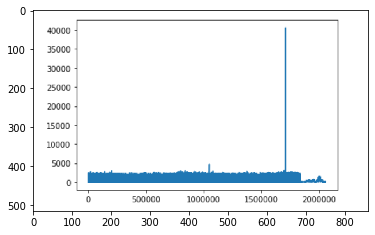

In [15]:
img  = mpimg.imread('true_plot.png')
imgplot = plt.imshow(img)
plt.show()


# Close Session

In [ ]:
sess.close()

# Preditions

# Conclusion
LSTM works fine on Time series but one needs care so that things do not blow up.
On a very suphiscated machine, this model could work impeccably well.
ARIMA,SARIMA are also very powerful models but they have less representational power compared to lstm
